In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, minmax_scale
import seaborn as sns
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
import datetime
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
import math

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
train["Junction"].value_counts()

3    14592
2    14592
1    14592
4     4344
Name: Junction, dtype: int64

In [6]:
train.dtypes

DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

### 1st we need to change the data type of DateTime which is object. After we change it into DateTime, we will have all the properties from pandas to work on datetime

In [5]:
train["DateTime"] = pd.to_datetime(train["DateTime"])
test["DateTime"] = pd.to_datetime(test["DateTime"])

In [6]:
train.dtypes

DateTime    datetime64[ns]
Junction             int64
Vehicles             int64
ID                   int64
dtype: object

In [7]:
train["Year"] = train["DateTime"].dt.year
train["Month"] = train["DateTime"].dt.month
train["Hour"] = train["DateTime"].dt.hour
#dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
train["Weekday"] = train["DateTime"].dt.dayofweek

test["Year"] = test["DateTime"].dt.year
test["Month"] = test["DateTime"].dt.month
test["Hour"] = test["DateTime"].dt.hour
#dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
test["Weekday"] = test["DateTime"].dt.dayofweek

In [9]:
train.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Hour,Weekday
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,0,6
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,6
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,2,6
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,3,6
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,4,6


In [8]:
train.drop(["DateTime"],axis = 1, inplace = True)
test.drop(["DateTime"],axis = 1, inplace = True)

In [11]:
train.head()

,Junction,Vehicles,ID,Year,Month,Hour,Weekday
0,1,15,20151101001,2015,11,0,6
1,1,13,20151101011,2015,11,1,6
2,1,10,20151101021,2015,11,2,6
3,1,7,20151101031,2015,11,3,6
4,1,9,20151101041,2015,11,4,6


### 1. Missing values

In [12]:
train.isna().sum()

Junction    0
Vehicles    0
ID          0
Year        0
Month       0
Hour        0
Weekday     0
dtype: int64

In [13]:
test.isna().sum()

Junction    0
ID          0
Year        0
Month       0
Hour        0
Weekday     0
dtype: int64

### 2. Feature Engineering

In [12]:
train.loc[train["Year"] == 2015,"Month"].unique()

array([11, 12], dtype=int64)

In [13]:
train.loc[train["Year"] == 2016,"Month"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [14]:
train.loc[train["Year"] == 2017,"Month"].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

*** As we can see above, the Year 2015 has only 2 months i.e. 11 and 12 and we need to predict for 7,8,9,10 months. We can drop this year. 

In [15]:
train = train[train["Year"] != 2015]

In [16]:
train["Year"].unique()

array([2016, 2017], dtype=int64)

### 2. Visualization

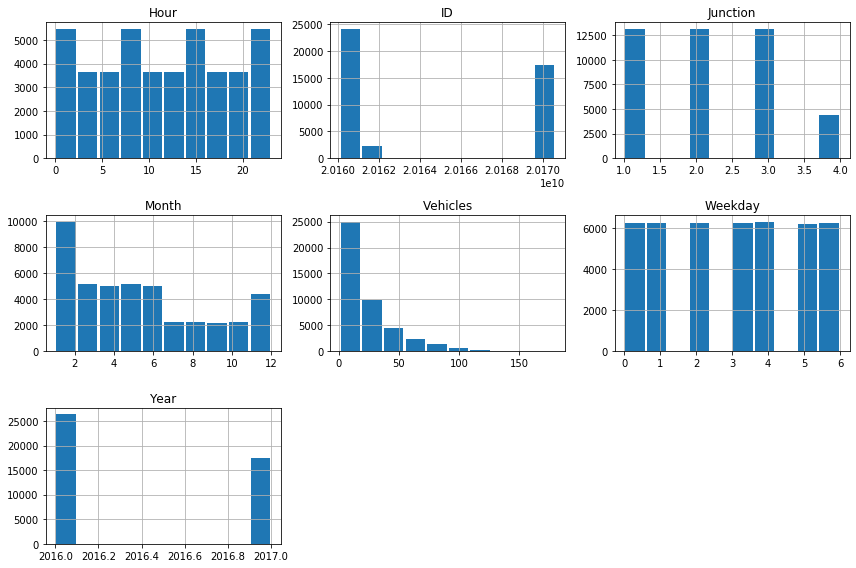

In [17]:

train.hist(rwidth = 0.9, figsize=(12,8))
plt.tight_layout()

### Observation :
1. Vehicles is not normally distributed


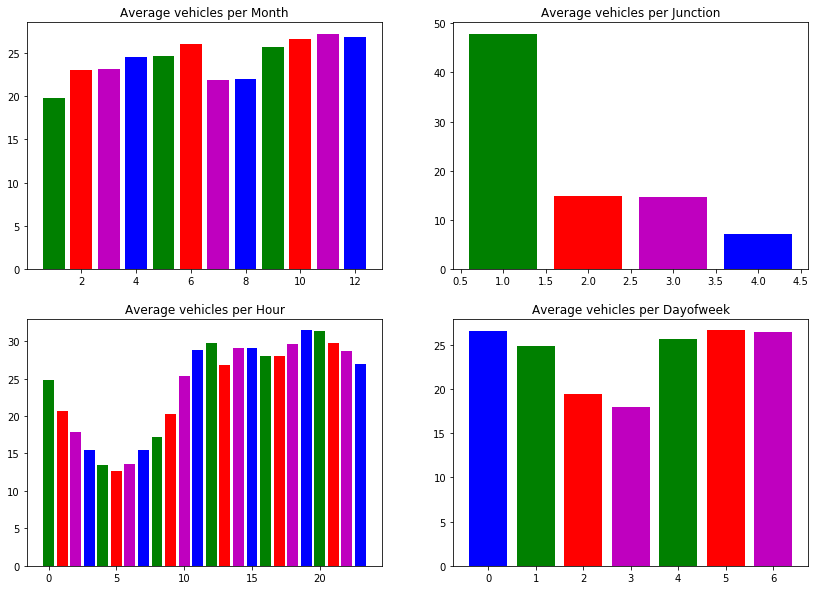

In [21]:
colors = ['g', 'r', 'm', 'b']

plt.figure(figsize = (14,10))
plt.subplot(2,2,1)
plt.title('Average vehicles per Month')
cat_list = train['Month'].unique()
cat_average = train.groupby('Month').mean()['Vehicles']
plt.bar(cat_list, cat_average, color=colors)

plt.subplot(2,2,2)
plt.title('Average vehicles per Junction')
cat_list = train['Junction'].unique()
cat_average = train.groupby('Junction').mean()['Vehicles']
plt.bar(cat_list, cat_average, color=colors)

plt.subplot(2,2,3)
plt.title('Average vehicles per Hour')
cat_list = train['Hour'].unique()
cat_average = train.groupby('Hour').mean()['Vehicles']
plt.bar(cat_list, cat_average, color=colors)

plt.subplot(2,2,4)
plt.title('Average vehicles per Dayofweek')
cat_list = train['Weekday'].unique()
cat_average = train.groupby('Weekday')['Vehicles'].mean()
plt.bar(cat_list, cat_average, color=colors)

plt.show()

In [18]:
df = pd.DataFrame(train.groupby(['Junction','Weekday'])["Vehicles"].sum())

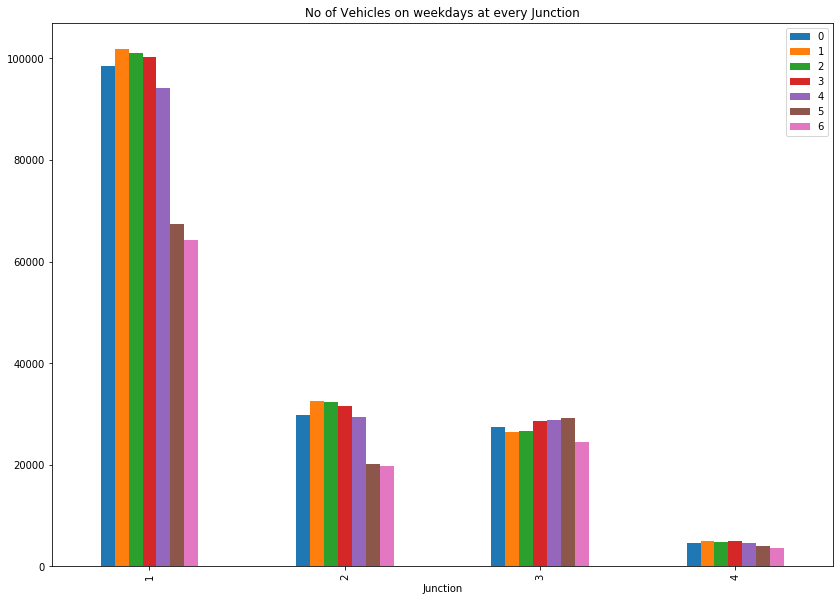

In [44]:
fig,ax = subplots()
df.unstack().plot(kind = "bar",figsize = (14,10),ax = ax, title = "No of Vehicles on weekdays at every Junction")
ax.legend(df.unstack().columns.get_level_values(1))
plt.show()

In [19]:
df1 = pd.DataFrame(train.groupby(['Junction','Hour'])["Vehicles"].sum())

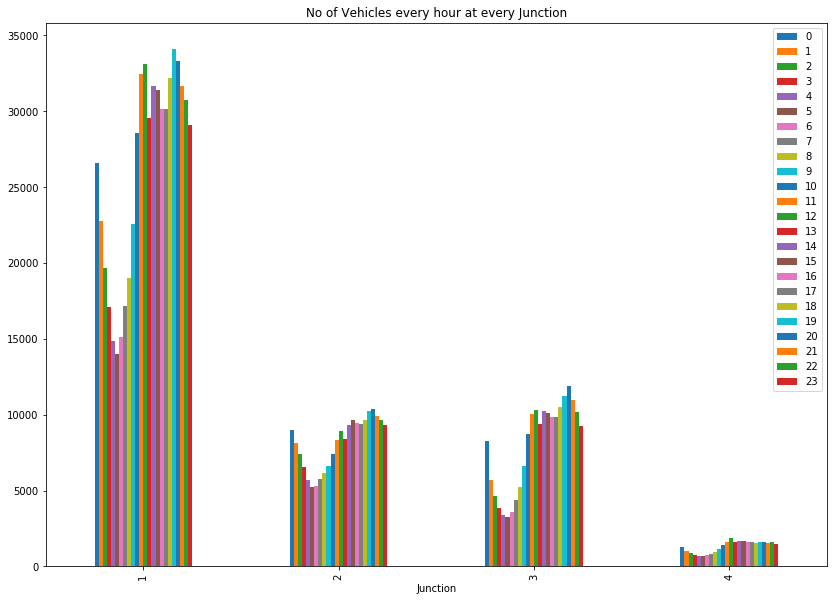

In [46]:
fig,ax = subplots()
df1.unstack().plot(kind = "bar",figsize = (14,10),ax = ax, title = "No of Vehicles every hour at every Junction")
ax.legend(df1.unstack().columns.get_level_values(1))
plt.show()

### Observation
1. Junction 1 has highest no of vehicles irrespective of hour or dayof week.
2. Hour is correlated to Vehicles - Early morning has less congestion
3. Month and day of week has least affect on Vehicles

### 3. Normality

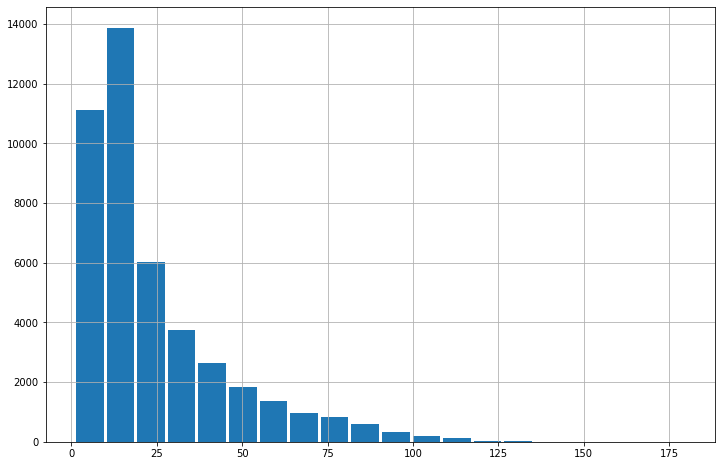

In [47]:
plt.figure(figsize = (12,8))
train['Vehicles'].hist(rwidth=0.9, bins=20)

In [20]:
df = np.log(train['Vehicles'])

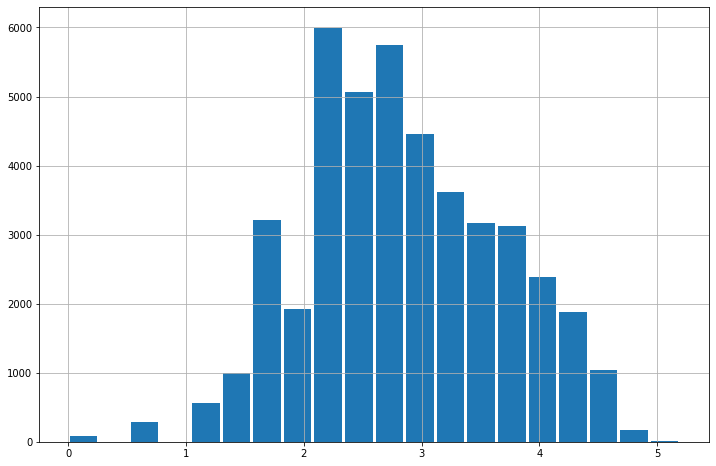

In [49]:
plt.figure(figsize = (12,8))
df.hist(rwidth=0.9, bins=20)

### As we see above, log resolves the issue of normality. 

In [21]:
train["Vehicles"] = np.log(train['Vehicles'])

In [22]:
train.head()

,Junction,Vehicles,ID,Year,Month,Hour,Weekday
1464,1,2.564949,20160101001,2016,1,0,4
1465,1,2.564949,20160101011,2016,1,1,4
1466,1,2.397895,20160101021,2016,1,2,4
1467,1,1.791759,20160101031,2016,1,3,4
1468,1,2.079442,20160101041,2016,1,4,4


In [23]:
target = "Vehicles"
IDcol = ["ID"]

### 4. Train Test Split

In [24]:

X = train.drop(['Vehicles','ID'], axis=1)
Y = train[['Vehicles']]

tr_size = 0.7 * len(X)
tr_size = int(tr_size)

X_train = X.values[0 : tr_size]
X_test = X.values[tr_size : len(X)]

Y_train = Y.values[0 : tr_size]
Y_test = Y.values[tr_size : len(Y)]

In [46]:
Y.head()

,Vehicles
1464,2.564949
1465,2.564949
1466,2.397895
1467,1.791759
1468,2.079442


In [44]:
X_train.shape,Y_train.shape

((30609, 5), (30609, 1))

### 5. Model

## LightGBM

In [25]:
#import lightgbm as lgb
from lightgbm import LGBMRegressor


In [39]:
lgbm =  LGBMRegressor(num_leaves=125,learning_rate=2,max_depth=5,objective="regression")

In [40]:
lgbm_fit = lgbm.fit(X_train,Y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
lgbm_pred_train = lgbm.predict(X_train)
lgbm_pred_test = lgbm.predict(X_test)

In [48]:
lgbm_pred_test.shape,Y_test.shape

((13119,), (13119, 1))

In [49]:
print("Training RMSE = {}".format(math.sqrt(mean_squared_error(Y_train, lgbm_pred_train))))
print("Test RMSE = {}".format(math.sqrt(mean_squared_error(Y_test, lgbm_pred_test))))

Training RMSE = 0.8172551611153737
Test RMSE = 0.9636578566022088


## Random Forest

In [34]:
rfr = RandomForestRegressor(max_depth=12, n_estimators=100, random_state=False, verbose=True)

In [35]:
rfr_fit = rfr.fit(X_train,Y_train)

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.7s finished


In [36]:
rfr_predict_test = rfr.predict(X_test)
rfr_predict_train = rfr.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [37]:
print("Training RMSE = {}".format(math.sqrt(mean_squared_error(Y_train, rfr_predict_train))))
print("Test RMSE = {}".format(math.sqrt(mean_squared_error(Y_test, rfr_predict_test))))

Training RMSE = 0.22467633383454286
Test RMSE = 0.8599356319147781


### We will use Random Forest

In [51]:
features = [x for x in train.columns if x not in [target]+IDcol]

In [53]:
test["Vehicles"] = rfr.predict(test[features])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [54]:
IDcol.append(target)
submission = test[IDcol]

In [55]:
submission.head()

,ID,Vehicles
0,20170701001,4.207648
1,20170701011,4.052511
2,20170701021,3.867896
3,20170701031,3.641781
4,20170701041,3.492056


In [56]:
submission.to_csv("submission.csv",index = False)